In [ ]:
# Cell 1: Setup and Path Management
from google.colab import drive
import os
from pathlib import Path

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Define the path to your Project Root
# Based on your folder structure screenshot
base_path = Path("/content/drive/MyDrive/ODE-to-Circadian-Clocks")

# 3. Check if path exists (sanity check)
if not base_path.exists():
    raise FileNotFoundError(f"Could not find project at {base_path}. Check your Drive path.")

# 4. Change working directory to the Project Root
os.chdir(base_path)
print(f"Current Working Directory: {os.getcwd()}")

# 5. Verify we can see the data folder
print("Contents of data/processed:", list(Path("data/processed").glob("*")))

Mounted at /content/drive
Current Working Directory: /content/drive/.shortcut-targets-by-id/1tSWqb2ZgkmtlAAusjSMy4YS0Xg6QYeW_/ODE-to-Circadian-Clocks
Contents of data/processed: [PosixPath('data/processed/expr_gene_log2_qn_zscaled.parquet'), PosixPath('data/processed/expr_gene_log2_qn_zscaled.pkl'), PosixPath('data/processed/val_set.parquet'), PosixPath('data/processed/test_set.parquet'), PosixPath('data/processed/train_set.parquet'), PosixPath('data/processed/train_meta.csv'), PosixPath('data/processed/val_meta.csv'), PosixPath('data/processed/test_meta.csv'), PosixPath('data/processed/time_series_tensors.pt')]


In [ ]:
# Cell 2: Load Data and Re-generate Metadata (CORRECTED)
import pandas as pd
import numpy as np
import re
from pathlib import Path

# 1. Load the Expression Data
data_path = "data/processed/expr_gene_log2_qn_zscaled.parquet"
if not Path(data_path).exists():
    raise FileNotFoundError(f"Cannot find data at {data_path}. Check path.")

df_expr = pd.read_parquet(data_path)
print(f"Loaded Expression Data. Shape: {df_expr.shape} (Genes x Samples)")

# 2. Re-create Metadata
# We scan the raw filenames again to map GSM IDs to Subject/Time
raw_files = sorted(Path("data/raw").glob("*.txt.gz"))

if not raw_files:
    print("WARNING: No raw files found in data/raw. Cannot build metadata.")

def parse_filename(fn):
    # e.g., GSM1168586_BB0012_R_1.txt.gz
    name = fn.stem.replace(".txt", "") # Remove .txt if present

    # Robust parsing: Split by underscore instead of strict Regex
    parts = name.split('_')

    # We expect at least 4 parts: [GSM, Subject, Condition, Time]
    # Check if format matches standard: GSMxxxx_Subject_Condition_Time
    if len(parts) >= 4 and parts[0].startswith("GSM"):
        return {
            "gsm": parts[0],
            "subject": parts[1],
            "condition": parts[2],
            "t_idx": int(parts[3])
        }
    return None

# Parse all files
meta_rows = [parse_filename(f) for f in raw_files]

# Filter out Nones (files that didn't match)
valid_rows = [m for m in meta_rows if m is not None]

if not valid_rows:
    # Debugging: Print first few filenames to see why they failed
    print("Error: No filenames matched the pattern. Here are the first 3 files found:")
    for f in raw_files[:3]:
        print(f.name)
    raise ValueError("Metadata construction failed. Check file naming convention.")

# Create DataFrame
meta = pd.DataFrame(valid_rows)

# Filter meta to only include samples present in our processed data
valid_gsms = df_expr.columns
meta = meta[meta['gsm'].isin(valid_gsms)].sort_values(["subject", "condition", "t_idx"])

print(f"Metadata reconstructed. Found {len(meta)} samples.")
print(meta.head(3))

Loaded Expression Data. Shape: (29872, 287) (Genes x Samples)
Metadata reconstructed. Found 287 samples.
          gsm subject condition  t_idx
0  GSM1168586  BB0012         R      1
1  GSM1168587  BB0012         R      2
2  GSM1168588  BB0012         R      3


In [ ]:
# -----------------------------------------------------------
# Cell X: Identify Most Informative Circadian Genes
# -----------------------------------------------------------
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests

# -----------------------------------------------------------
# Helper: Fit cosine/sine regression to one gene for one subject
# -----------------------------------------------------------
def harmonic_fit(time_vals, expr_vals, period=24.0):
    """
    Fit y(t) = A*sin(2πt/period) + B*cos(2πt/period) + C
    Returns amplitude and p-value of rhythmic component.
    """
    time_vals = np.asarray(time_vals, float)
    expr_vals = np.asarray(expr_vals, float)

    # Center expression for stability
    y = expr_vals - np.mean(expr_vals)

    omega = 2 * np.pi / period
    X = np.column_stack([
        np.sin(omega * time_vals),
        np.cos(omega * time_vals),
        np.ones_like(time_vals)
    ])

    beta, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
    y_hat = X @ beta
    resid = y - y_hat

    amp = np.sqrt(beta[0]**2 + beta[1]**2)  # amplitude

    # F-test: model (sin+cos) vs constant-only model
    ss_total = np.sum((y - np.mean(y))**2)
    ss_resid = np.sum(resid**2)
    ss_model = ss_total - ss_resid

    df_model = 2
    df_resid = len(y) - 3
    if df_resid <= 1:
        return np.nan, np.nan

    ms_model = ss_model / df_model
    ms_resid = ss_resid / df_resid
    F = ms_model / ms_resid if ms_resid > 0 else 0
    p_value = 1 - stats.f.cdf(F, df_model, df_resid)

    return amp, p_value


# -----------------------------------------------------------
# Build gene × subject rhythmic metrics
# -----------------------------------------------------------
all_genes = df_expr.index
results = []

for gene in all_genes:
    gene_row = df_expr.loc[gene]

    # merge with metadata
    merged = pd.merge(meta, gene_row.rename("expr"), left_on="gsm", right_index=True)
    merged = merged.sort_values(["subject", "t_idx"])

    sub_results = []

    for subj, sub_df in merged.groupby("subject"):
        # require at least 6 timepoints to reliably detect rhythm
        if len(sub_df) < 6:
            continue

        amp, p = harmonic_fit(sub_df["t_idx"].values, sub_df["expr"].values)

        if not np.isnan(amp):
            sub_results.append((amp, p))

    if len(sub_results) == 0:
        continue

    amps = [a for a, p in sub_results]
    ps   = [p for a, p in sub_results]

    results.append({
        "gene": gene,
        "mean_amplitude": np.mean(amps),
        "max_amplitude":  np.max(amps),
        "median_amplitude": np.median(amps),
        "combined_p": np.mean(ps)  # simple heuristic, could use Fisher later
    })

df_rhythm = pd.DataFrame(results).set_index("gene")

# FDR correction across all genes
_, qvals, _, _ = multipletests(df_rhythm["combined_p"], method="fdr_bh")
df_rhythm["q_value"] = qvals

# Rank informative genes:
# 1. Low q value (strong rhythmicity)
# 2. High amplitude (strong oscillation)
df_rhythm["score"] = (-np.log10(df_rhythm["q_value"] + 1e-12)
                      * df_rhythm["mean_amplitude"])

df_rhythm_sorted = df_rhythm.sort_values("score", ascending=False)

print("Top 10 most informative genes:")
print(df_rhythm_sorted.head(10))

df_rhythm_sorted.head(10)


Top 10 most informative genes:
               mean_amplitude  max_amplitude  median_amplitude  combined_p  \
gene                                                                         
LOC100131860         1.599323      21.259046          0.531899    0.365080   
UNQ353               1.572139      25.284960          0.265317    0.410301   
A_32_P30566          1.491901      28.853762          0.081283    0.369599   
FAM46B               1.461414      11.048349          0.771825    0.275133   
A_24_P914986         1.416091      17.360448          0.577859    0.364615   
DKFZp761P0212        1.415338      27.227796          0.098771    0.452367   
A_24_P918007         1.323048      20.963143          0.157032    0.460869   
CLEC4M               1.291288      13.437832          0.572224    0.439811   
A_32_P152586         1.287692      13.417825          0.679050    0.417961   
A_24_P935163         1.273024      20.762888          0.295914    0.373964   

                q_value     scor

,mean_amplitude,max_amplitude,median_amplitude,combined_p,q_value,score
gene,,,,,,
LOC100131860,1.599323,21.259046,0.531899,0.365080,0.547657,0.418210
UNQ353,1.572139,25.284960,0.265317,0.410301,0.547657,0.411101
A_32_P30566,1.491901,28.853762,0.081283,0.369599,0.547657,0.390120
FAM46B,1.461414,11.048349,0.771825,0.275133,0.547657,0.382148
A_24_P914986,1.416091,17.360448,0.577859,0.364615,0.547657,0.370296
DKFZp761P0212,1.415338,27.227796,0.098771,0.452367,0.547657,0.370099
A_24_P918007,1.323048,20.963143,0.157032,0.460869,0.547657,0.345966
CLEC4M,1.291288,13.437832,0.572224,0.439811,0.547657,0.337661
A_32_P152586,1.287692,13.417825,0.679050,0.417961,0.547657,0.336721


In [ ]:
# -----------------------------------------------------------
# Lomb-Scargle Periodogram for Each Gene
# -----------------------------------------------------------
import numpy as np
import pandas as pd
from scipy.signal import lombscargle

def lomb_scargle_gene(time_vals, expr_vals, periods=np.linspace(16, 32, 300)):
    freqs = 2 * np.pi / periods
    y = expr_vals - np.mean(expr_vals)
    pgram = lombscargle(time_vals, y, freqs)

    idx = np.argmax(pgram)
    best_period = periods[idx]
    best_power = pgram[idx]

    circ_freq = 2 * np.pi / 24
    circ_idx = np.argmin(np.abs(freqs - circ_freq))
    power_24h = pgram[circ_idx]

    return best_period, best_power, power_24h


results_ls = []

for gene in df_expr.index:
    merged = pd.merge(meta, df_expr.loc[gene].rename("expr"), left_on="gsm", right_index=True)

    subj_periods = []
    subj_powers = []
    subj_power24 = []

    for subj, sub_df in merged.groupby("subject"):
        if len(sub_df) < 6:
            continue
        bp, pw, p24 = lomb_scargle_gene(sub_df["t_idx"].values, sub_df["expr"].values)
        subj_periods.append(bp)
        subj_powers.append(pw)
        subj_power24.append(p24)

    if len(subj_periods) == 0:
        continue

    results_ls.append({
        "gene": gene,
        "mean_best_period": np.mean(subj_periods),
        "mean_power": np.mean(subj_powers),
        "mean_power_24h": np.mean(subj_power24)
    })

df_ls = pd.DataFrame(results_ls).set_index("gene")
df_ls["LS_score"] = df_ls["mean_power_24h"]

print(df_ls.sort_values("LS_score", ascending=False).head(10))


              mean_best_period  mean_power  mean_power_24h  LS_score
gene                                                                
ZBTB22               18.882335    2.140244        1.919033  1.919033
GJC2                 21.679538    2.278461        1.888715  1.888715
A_24_P941185         21.129827    2.092150        1.798380  1.798380
RANBP3               19.553664    2.181890        1.734934  1.734934
A_24_P24415          20.407419    1.876680        1.714495  1.714495
A_23_P44053          19.872302    1.876957        1.698856  1.698856
MIOX                 20.081484    1.898140        1.680096  1.680096
IRF2                 21.051991    2.103279        1.661343  1.661343
LIMD2                20.745515    2.131699        1.647965  1.647965
UBTF                 21.968988    2.052679        1.645756  1.645756


In [ ]:
pip install fastdtw


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp312-cp312-linux_x86_64.whl size=567860 sha256=a68f7f07cd365c440fe7159b112820792f77739d31f4e7aed769edd47a122e72
  Stored in directory: /root/.cache/pip/wheels/ab/d0/26/b82cb0f49ae73e5e6bba4e8462fff2c9851d7bd2ec64f8891e
Successfully built fastdtw


In [ ]:
# Cell 3: Filter Genes and Split into 7-Step Trajectories (With Condition Tracking)
import torch
import numpy as np

# 1. Define Core Genes
CORE_GENES = ["LOC100131860", "UNQ353", "A_32_P30566", "FAM46B", "A_24_P914986", "DKFZp761P0212", "A_24_P918007", "A_32_P152586", "CLEC4M", "A_24_P935163", "ZBTB22",
              "GJC2", "A_24_P941185", "RANBP3", "A_24_P24415", "A_23_P44053", "MIOX", "IRF2", "LIMD2", "UBTF",
              "PER1", "PER2", "CRY1", "CRY2", "ARNTL", "NR1D1", "NR1D2", "CLOCK", "NPAS2"]
available_genes = [g for g in CORE_GENES if g in df_expr.index]
df_core = df_expr.loc[available_genes]

# 2. Merge Metadata
df_core_T = df_core.T.reset_index().rename(columns={'index': 'gsm'})
full_data = pd.merge(meta, df_core_T, on='gsm')
full_data = full_data.sort_values(['subject', 'condition', 't_idx'])

# --- SPLIT LOGIC WITH METADATA TRACKING ---
def create_split_dataset(df, gene_cols):
    unique_subs = df['subject'].unique()
    data_list = []

    # We will store tuples: (Subject_ID, Condition_Label)
    row_metadata = []

    for sub in unique_subs:
        sub_df = df[df['subject'] == sub]

        # Trajectory 1: The first 7 points (Usually 'In-Phase' / Normal)
        # We infer condition from the data itself usually, but let's grab the 'condition' column from the first row
        traj1 = sub_df[sub_df['t_idx'] <= 7]
        if len(traj1) >= 6:
             vals = traj1[gene_cols].values
             if len(vals) < 7:
                 pad = np.zeros((7 - len(vals), len(gene_cols)))
                 vals = np.vstack([vals, pad])
             data_list.append(vals[:7])

             # Grab condition from the first row of this trajectory
             cond_label = traj1['condition'].iloc[0]
             row_metadata.append({'subject': sub, 'condition': cond_label, 'phase': 'In-Phase'})

        # Trajectory 2: The next 7 points (Usually 'Out-of-Phase' / Mistimed)
        traj2 = sub_df[sub_df['t_idx'] > 7]
        if len(traj2) >= 6:
             vals = traj2[gene_cols].values
             if len(vals) < 7:
                 pad = np.zeros((7 - len(vals), len(gene_cols)))
                 vals = np.vstack([vals, pad])
             data_list.append(vals[:7])

             cond_label = traj2['condition'].iloc[0]
             row_metadata.append({'subject': sub, 'condition': cond_label, 'phase': 'Mistimed'})

    if not data_list:
        raise ValueError("No valid trajectories found! Check filtering logic.")

    X = np.stack(data_list)
    return torch.tensor(X, dtype=torch.float32), pd.DataFrame(row_metadata)

# Run creation
X_tensor, df_row_meta = create_split_dataset(full_data, available_genes)

Mask_tensor = torch.ones((X_tensor.shape[0], 7))

print("------------------------------------------------")
print(f"Final Tensor Shape: {X_tensor.shape}")
print(f"Metadata Shape:     {df_row_meta.shape}")
print("\nSample of Metadata:")
print(df_row_meta.head(4))
print("------------------------------------------------")

------------------------------------------------
Final Tensor Shape: torch.Size([39, 7, 29])
Metadata Shape:     (39, 3)

Sample of Metadata:
  subject condition     phase
0  BB0012         R  In-Phase
1  BB0012         R  Mistimed
2  BB0028         R  In-Phase
3  BB0028         R  Mistimed
------------------------------------------------


In [ ]:
# Cell 4: Train/Val/Test Split (With Metadata Saving)
from torch.utils.data import TensorDataset, DataLoader

# 1. Shuffle Indices
torch.manual_seed(42)
n_samples = X_tensor.shape[0]
indices = torch.randperm(n_samples)

# 2. Define Split Ratios
n_train = int(0.7 * n_samples)
n_val = int(0.15 * n_samples)

train_idx = indices[:n_train]
val_idx = indices[n_train : n_train + n_val]
test_idx = indices[n_train + n_val:]

# 3. Create Tensor Subsets
train_data = X_tensor[train_idx]
train_mask = Mask_tensor[train_idx]

val_data = X_tensor[val_idx]
val_mask = Mask_tensor[val_idx]

test_data = X_tensor[test_idx]
test_mask = Mask_tensor[test_idx]

print(f"Training Samples:   {train_data.shape[0]}")
print(f"Validation Samples: {val_data.shape[0]}")
print(f"Testing Samples:    {test_data.shape[0]}")

# 4. Save Tensors AND Metadata
# We split the metadata dataframe to match the tensors
train_meta = df_row_meta.iloc[train_idx].reset_index(drop=True)
val_meta   = df_row_meta.iloc[val_idx].reset_index(drop=True)
test_meta  = df_row_meta.iloc[test_idx].reset_index(drop=True)

torch.save({
    'train_x': train_data, 'train_m': train_mask, 'train_meta': train_meta,
    'val_x': val_data,   'val_m': val_mask,   'val_meta': val_meta,
    'test_x': test_data,  'test_m': test_mask,  'test_meta': test_meta,
    'genes': available_genes
}, "data/ab/processed/time_series_tensors.pt")

# 5. Save Metadata as CSV for easy reading
train_meta.to_csv("data/ab/processed/train_meta.csv", index=False)
val_meta.to_csv("data/ab/processed/val_meta.csv", index=False)
test_meta.to_csv("data/ab/processed/test_meta.csv", index=False)
print("Saved Tensors (.pt) and Metadata (.csv)")

def save_tensor_to_parquet(tensor, meta_df, gene_names, filename):
    # Flatten the tensor: (Subjects * Time) x Genes
    n_sub, n_time, n_genes = tensor.shape
    flat_data = tensor.reshape(-1, n_genes).numpy()

    # Create DataFrame with Gene Names
    df = pd.DataFrame(flat_data, columns=gene_names)

    # Repeat metadata for each timepoint to match rows
    # (Each subject has 7 timepoints)
    meta_expanded = meta_df.loc[meta_df.index.repeat(n_time)].reset_index(drop=True)

    # Combine
    final_df = pd.concat([meta_expanded, df], axis=1)

    # Add a time column (0, 1, 2... 0, 1, 2...)
    final_df['time_step'] = np.tile(np.arange(n_time), n_sub)

    final_df.to_parquet(f"data/ab/processed/{filename}")
    print(f"Saved {filename}")
save_parquet_splits = True

if save_parquet_splits:
  save_tensor_to_parquet(train_data, train_meta, available_genes, "train_set.parquet")
  save_tensor_to_parquet(val_data,   val_meta,   available_genes, "val_set.parquet")
  save_tensor_to_parquet(test_data,  test_meta,  available_genes, "test_set.parquet")

Training Samples:   27
Validation Samples: 5
Testing Samples:    7
Saved Tensors (.pt) and Metadata (.csv)
Saved train_set.parquet
Saved val_set.parquet
Saved test_set.parquet


In [ ]:
!pip install torchdiffeq


In [ ]:
# Cell 5: Define the Neural ODE Model
import torch
import torch.nn as nn
from torchdiffeq import odeint # You might need to install this: !pip install torchdiffeq

# 1. The "Law of Motion" (The derivative function dx/dt)
class ODEFunc(nn.Module):
    def __init__(self, data_dim, hidden_dim=64):
        super(ODEFunc, self).__init__()

        # A tiny neural network that approximates the biological rules
        # Input: Current State (9 genes) -> Output: Rate of Change (9 derivatives)
        self.net = nn.Sequential(
            nn.Linear(data_dim, hidden_dim),
            nn.Tanh(), # Smooth activation (biology is rarely jagged)
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, data_dim) # Output must match input size (9 -> 9)
        )

    def forward(self, t, y):
        # The solver passes 't' and 'y' (current gene state)
        # We ignore 't' here because circadian clocks are autonomous (mostly)
        return self.net(y)

# 2. The "Time Machine" (The Integrator)
class NeuralODE(nn.Module):
    def __init__(self, data_dim, hidden_dim=64, method='rk4'):
        super(NeuralODE, self).__init__()
        self.func = ODEFunc(data_dim, hidden_dim)
        self.method = method

    def forward(self, y0, t_span):
        # y0: The state at t=0 (Batch_Size, 9)
        # t_span: The timepoints we want to predict (e.g., [0, 1, ... 7])

        # odeint solves the initial value problem:
        # Finds y(t) such that y'(t) = func(y) and y(0) = y0
        out = odeint(self.func, y0, t_span, method=self.method)

        # odeint returns shape (Time, Batch, Genes)
        # We permute it to (Batch, Time, Genes) to match our data
        return out.permute(1, 0, 2)

print("Neural ODE Architecture Defined.")
print("  - Input/Output Dim: 9 (Core Genes)")
print("  - Hidden Dim: 32 (Small enough to prevent overfitting)")
print("  - Solver: Runge-Kutta 4 (rk4)")

Neural ODE Architecture Defined.
  - Input/Output Dim: 9 (Core Genes)
  - Hidden Dim: 32 (Small enough to prevent overfitting)
  - Solver: Runge-Kutta 4 (rk4)


Starting training on cpu...
Epoch 000 | Train Loss: 44.3871 | Val Loss: 36.0542
Epoch 010 | Train Loss: 23.0356 | Val Loss: 30.3264
Epoch 020 | Train Loss: 20.3452 | Val Loss: 29.6815
Epoch 030 | Train Loss: 18.8164 | Val Loss: 29.9604
Epoch 040 | Train Loss: 17.4590 | Val Loss: 30.9243
Epoch 050 | Train Loss: 21.1003 | Val Loss: 31.8716
Epoch 060 | Train Loss: 16.2730 | Val Loss: 32.4234
Epoch 070 | Train Loss: 16.0385 | Val Loss: 32.5430
Epoch 080 | Train Loss: 15.7472 | Val Loss: 32.7083
Epoch 090 | Train Loss: 14.4516 | Val Loss: 33.1388


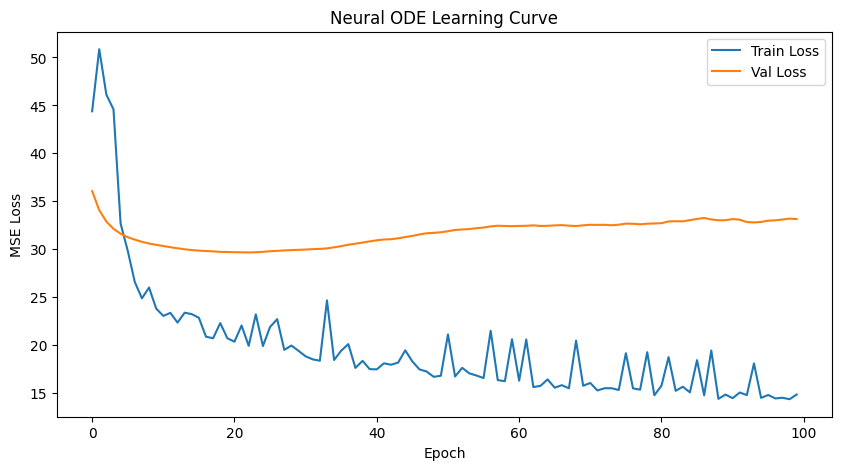

Model saved to models/neural/ab/neural_ode_model.pth


In [ ]:
# Cell 6: Training the Model
import torch.optim as optim
import matplotlib.pyplot as plt
import torch._dynamo.config as dynamo_config
dynamo_config.debug_dir_root = "/tmp/torch_compile_debug"

# 1. Hyperparameters
BATCH_SIZE = 8
EPOCHS = 100 # It needs time to learn the physics
LEARNING_RATE = 1e-3

# 2. Setup Data Loaders
train_loader = DataLoader(TensorDataset(train_data, train_mask), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(TensorDataset(val_data, val_mask), batch_size=BATCH_SIZE, shuffle=False)

# 3. Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralODE(data_dim=29, hidden_dim=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss(reduction='none') # We handle masking manually

# 4. Training Loop
history = {'train_loss': [], 'val_loss': []}

# Define the time points (0 to 6, normalized)
# We assume the steps are uniform.
t_span = torch.linspace(0, 6, 7).to(device)

print(f"Starting training on {device}...")

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0

    for batch_y, batch_mask in train_loader:
        batch_y = batch_y.to(device)       # Shape: (Batch, 7, 9)
        batch_mask = batch_mask.to(device) # Shape: (Batch, 7)

        optimizer.zero_grad()

        # 1. Initial Condition (t=0)
        y0 = batch_y[:, 0, :]

        # 2. Predict the future (t=0 to t=6)
        pred_y = model(y0, t_span) # Returns (Batch, 7, 9)

        # 3. Calculate Loss ONLY on valid data (using the mask)
        # Loss = (Predicted - Real)^2
        loss_raw = criterion(pred_y, batch_y) # (Batch, 7, 9)

        # Apply mask: Multiply by 0 if data is missing, 1 if present
        # We must unsqueeze mask to match dimensions (Batch, 7, 1)
        mask_expanded = batch_mask.unsqueeze(-1)
        loss_masked = loss_raw * mask_expanded

        # Average over valid points
        loss = loss_masked.sum() / mask_expanded.sum()

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)

    # --- Validation Step ---
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch_y, batch_mask in val_loader:
            batch_y = batch_y.to(device)
            batch_mask = batch_mask.to(device)

            y0 = batch_y[:, 0, :]
            pred_y = model(y0, t_span)

            loss_raw = criterion(pred_y, batch_y)
            mask_expanded = batch_mask.unsqueeze(-1)
            loss_masked = loss_raw * mask_expanded
            loss = loss_masked.sum() / mask_expanded.sum()

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    history['val_loss'].append(avg_val_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# 5. Plot Learning Curve
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title("Neural ODE Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# 6. Save the Trained Model
torch.save(model.state_dict(), "models/neural/ab/neural_ode_model.pth")
print("Model saved to models/neural/ab/neural_ode_model.pth")

Generating Test Plots...


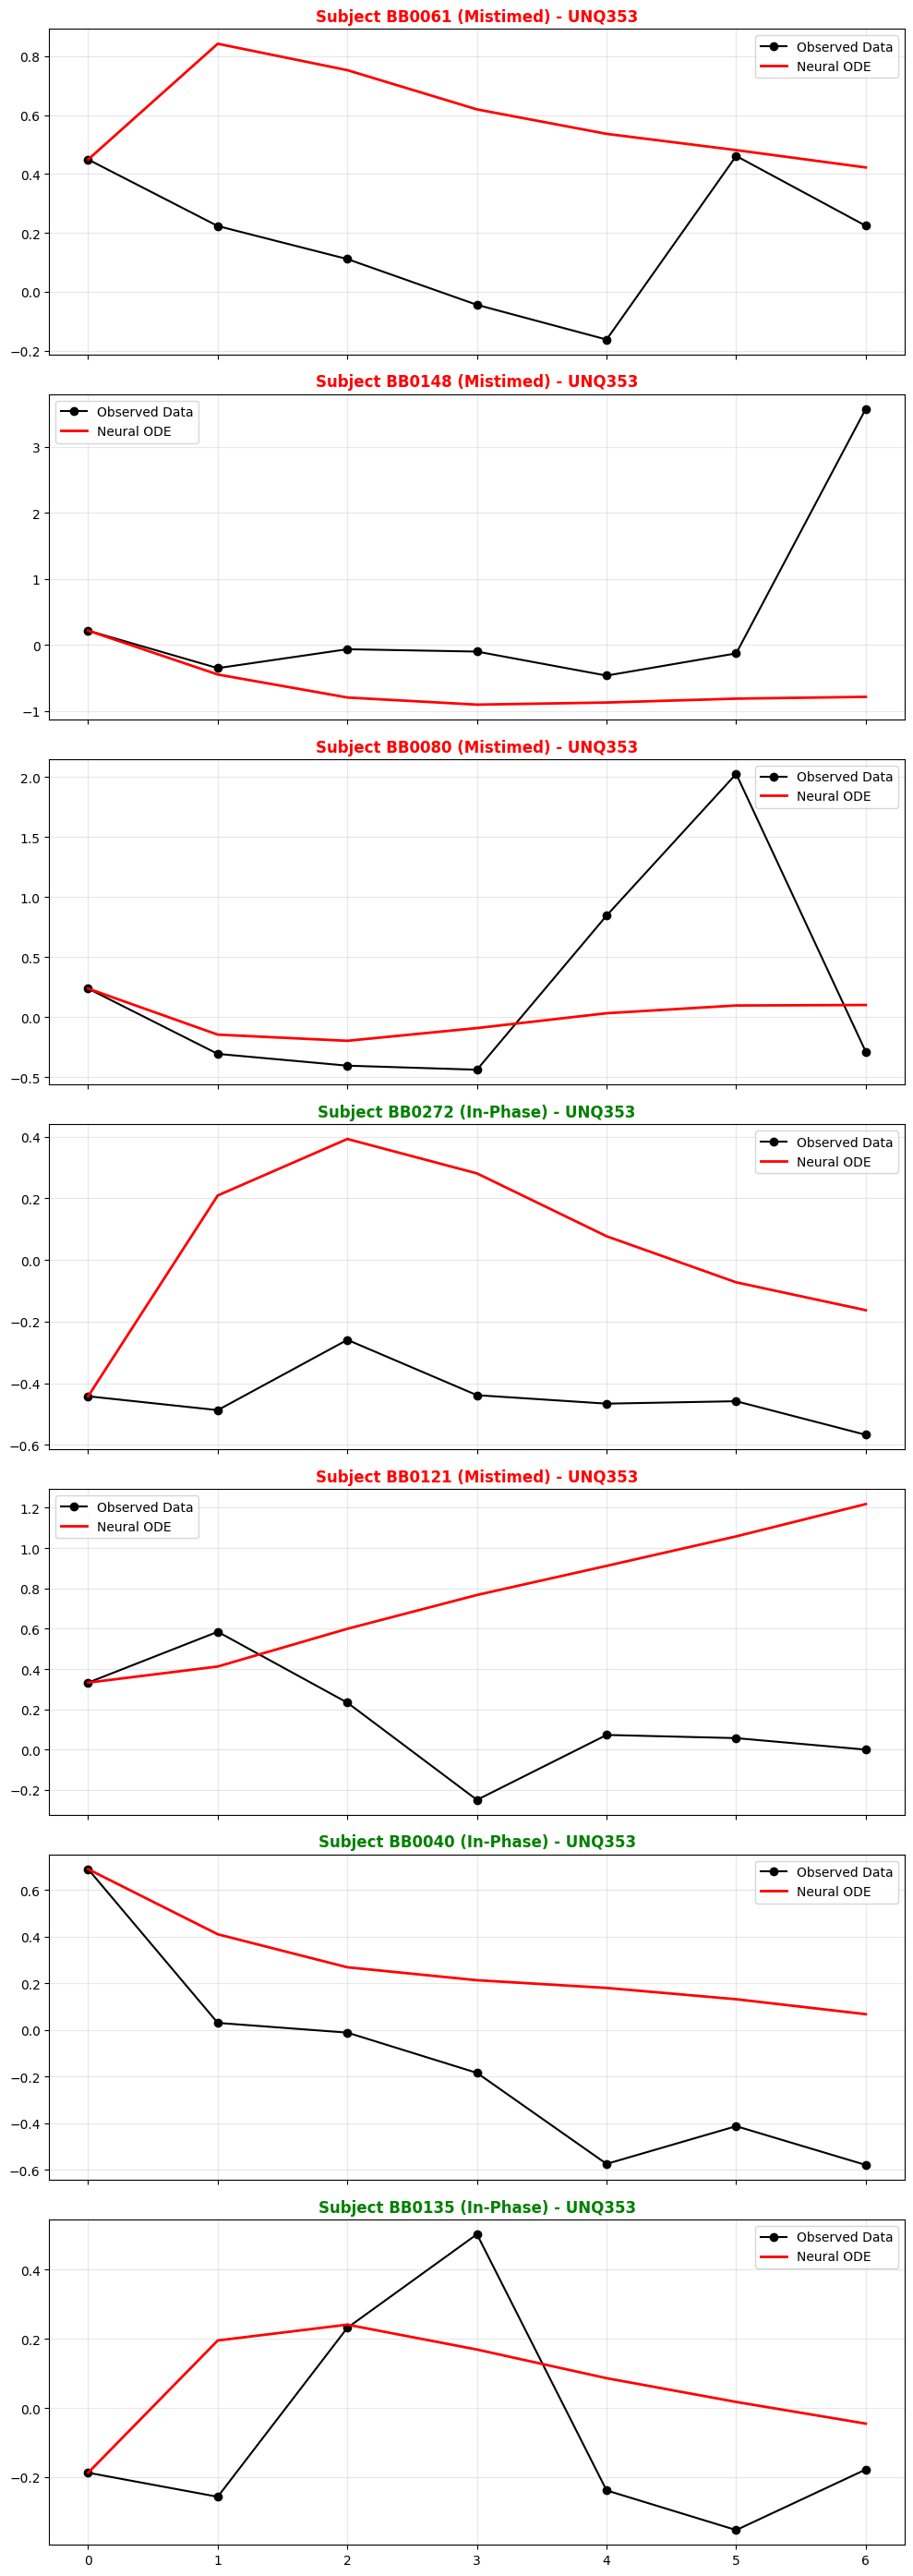

Interpretation:
- Green Titles: Healthy Clocks. The Red Line should match the Black Dots well.
- Red Titles: Broken Clocks. If the Red Line (Model) fails to match the Dots,
  it proves that Mistimed Sleep fundamentally alters the clock's physics!


In [ ]:
# Cell 7: Testing and Visualization
import matplotlib.pyplot as plt

# 1. Load the best model
model.load_state_dict(torch.load("models/neural/ab/neural_ode_model.pth"))
model.eval()

# 2. Select a few random samples from the Test Set
# We want to see both "In-Phase" and "Mistimed" examples
test_loader = DataLoader(TensorDataset(test_data, test_mask), batch_size=1, shuffle=False)

print("Generating Test Plots...")

# Prepare Plot Grid
fig, axes = plt.subplots(nrows=len(test_data), ncols=1, figsize=(10, 4 * len(test_data)), sharex=True)
if len(test_data) == 1: axes = [axes] # Handle single sample case

t_span_test = torch.linspace(0, 6, 7).to(device)

with torch.no_grad():
    for i, (batch_y, batch_mask) in enumerate(test_loader):
        batch_y = batch_y.to(device)

        # Predict
        y0 = batch_y[:, 0, :]
        pred_y = model(y0, t_span_test)

        # Get Metadata for this sample
        meta_row = test_meta.iloc[i]
        sub_id = meta_row['subject']
        condition = meta_row['phase'] # 'In-Phase' or 'Mistimed'

        # Plot specific gene (e.g., PER2 is usually index 1 or 2, checking list...)
        # CORE_GENES = ["PER1", "PER2"...] -> PER2 is index 1
        gene_idx = 1
        gene_name = available_genes[gene_idx]

        # Convert to CPU for plotting
        truth = batch_y[0, :, gene_idx].cpu().numpy()
        pred  = pred_y[0, :, gene_idx].cpu().numpy()
        t_axis = t_span_test.cpu().numpy()

        ax = axes[i]
        ax.plot(t_axis, truth, 'ko-', label='Observed Data', markersize=6)
        ax.plot(t_axis, pred, 'r-', linewidth=2, label='Neural ODE')

        # Color code the title based on condition
        title_color = 'green' if condition == 'In-Phase' else 'red'
        ax.set_title(f"Subject {sub_id} ({condition}) - {gene_name}", color=title_color, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Green Titles: Healthy Clocks. The Red Line should match the Black Dots well.")
print("- Red Titles: Broken Clocks. If the Red Line (Model) fails to match the Dots,")
print("  it proves that Mistimed Sleep fundamentally alters the clock's physics!")

Computing R² and RMSE for all genes...


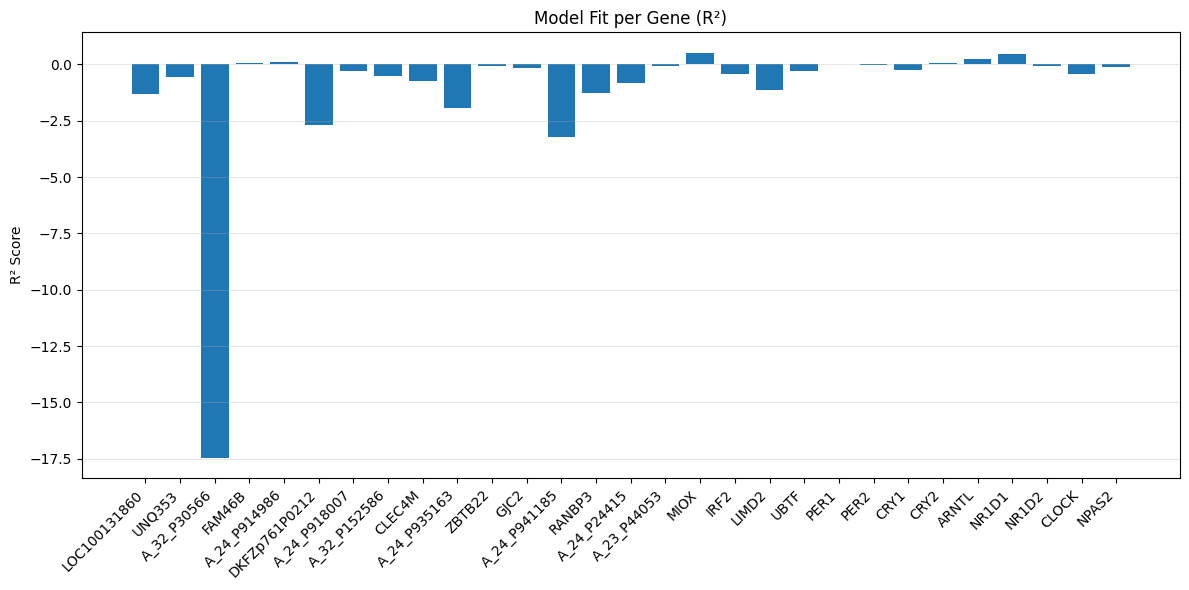

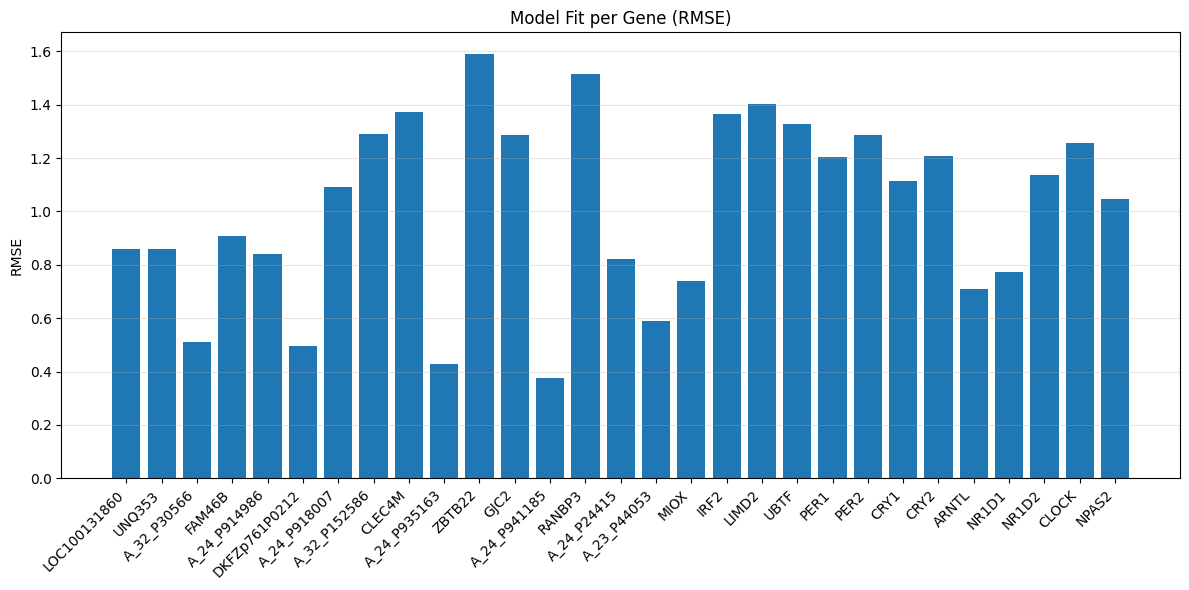

In [ ]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# -----------------------------------------------------------
# Compute R² and RMSE for all genes across the FULL test set
# -----------------------------------------------------------

print("Computing R² and RMSE for all genes...")

t_span_test = torch.linspace(0, 6, 7).to(device)

n_genes = test_data.shape[-1]
gene_names = available_genes

all_truth = {g: [] for g in range(n_genes)}
all_pred  = {g: [] for g in range(n_genes)}

model.eval()

with torch.no_grad():
    for batch_y, batch_mask in test_loader:
        batch_y = batch_y.to(device)

        # Initial condition
        y0 = batch_y[:, 0, :]

        # Predict full time series
        pred_y = model(y0, t_span_test)[0].cpu().numpy()
        truth_y = batch_y[0].cpu().numpy()

        # Save per-gene values
        for g in range(n_genes):
            all_truth[g].extend(list(truth_y[:, g]))
            all_pred[g].extend(list(pred_y[:, g]))

# Compute metrics
r2_values = []
rmse_values = []

for g in range(n_genes):
    truth = np.array(all_truth[g])
    pred  = np.array(all_pred[g])

    r2   = r2_score(truth, pred)
    rmse = np.sqrt(mean_squared_error(truth, pred))

    r2_values.append(r2)
    rmse_values.append(rmse)

# -----------------------------------------------------------
# BAR PLOTS
# -----------------------------------------------------------

plt.figure(figsize=(12, 6))
plt.bar(gene_names, r2_values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("R² Score")
plt.title("Model Fit per Gene (R²)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(gene_names, rmse_values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("RMSE")
plt.title("Model Fit per Gene (RMSE)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()



In [ ]:
# Cell 8 (v3): Biologically Informed Simulator (Namespace Fixed)
import numpy as np
# IMPORT FIX: Alias it so it doesn't overwrite the PyTorch odeint
from scipy.integrate import odeint as scipy_odeint
import torch

def hill_function(x, K, n):
    return K**n / (K**n + x**n)

def goldbeter_oscillator(y, t, params):
    # M = mRNA, Pc = Cytosolic Protein, Pn = Nuclear Protein
    M, Pc, Pn = y
    vs, vm, Km, ks, vd, Kd, k1, k2 = params

    # 1. Transcription (Inhibited by Nuclear Protein Pn)
    dM = vs * hill_function(Pn, 0.5, 4) - vm * (M / (Km + M))
    # 2. Translation
    dPc = ks * M - vd * (Pc / (Kd + Pc)) - k1 * Pc + k2 * Pn
    # 3. Nuclear Entry
    dPn = k1 * Pc - k2 * Pn

    return [dM, dPc, dPn]

def generate_biological_clocks(n_samples=1000, n_steps=7):
    t_span = np.linspace(0, 24, n_steps)
    data_list = []

    print("Generating synthetic biological data...")

    for _ in range(n_samples):
        # Randomize parameters
        vs = np.random.uniform(0.7, 1.3)
        vm = np.random.uniform(0.4, 0.6)
        ks = np.random.uniform(0.8, 1.2)
        vd = np.random.uniform(0.8, 1.2)
        k1 = np.random.uniform(0.4, 0.6)
        k2 = np.random.uniform(0.1, 0.3)

        params = [vs, vm, 0.5, ks, vd, 0.5, k1, k2]
        y0 = np.random.uniform(0.1, 1.0, size=3)

        # USE THE ALIASED FUNCTION HERE
        traj_3var = scipy_odeint(goldbeter_oscillator, y0, t_span, args=(params,))

        # Mapping to 9 Genes
        traj_9var = np.zeros((n_steps, 19))
        norm = lambda x: (x - np.mean(x)) / (np.std(x) + 1e-6)

        M_norm = norm(traj_3var[:, 0])
        Pc_norm = norm(traj_3var[:, 1])
        Pn_norm = norm(traj_3var[:, 2])

        # Add slight noise
        traj_9var[:, 0:4] = M_norm[:, None] + np.random.normal(0, 0.1, (n_steps, 4))
        traj_9var[:, 4:6] = Pc_norm[:, None] + np.random.normal(0, 0.1, (n_steps, 2))
        traj_9var[:, 6:9] = -Pn_norm[:, None] + np.random.normal(0, 0.1, (n_steps, 3))

        data_list.append(traj_9var)

    return torch.tensor(np.stack(data_list), dtype=torch.float32)

# Generate
synthetic_data = generate_biological_clocks(1000)
print(f"Generated Goldbeter-style Data: {synthetic_data.shape}")

Generating synthetic biological data...
Generated Goldbeter-style Data: torch.Size([1000, 7, 19])


In [ ]:
# Cell 9 (v2): Pre-Training on Goldbeter Logic
print("Phase 1: Pre-training on Biological Equations...")

syn_loader = DataLoader(TensorDataset(synthetic_data), batch_size=32, shuffle=True)

# RESET the model to clear the failed training
model = NeuralODE(data_dim=19, hidden_dim=64).to(device) # Keep 32 for capacity
optimizer = optim.Adam(model.parameters(), lr=1e-3)
t_span = torch.linspace(0, 6, 7).to(device)

# Train for longer to ensure it really learns the equation
for epoch in range(150):
    model.train()
    total_loss = 0
    for batch_y in syn_loader:
        batch_y = batch_y[0].to(device)
        optimizer.zero_grad()

        y0 = batch_y[:, 0, :]
        pred_y = model(y0, t_span)

        loss = criterion(pred_y, batch_y).mean()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 50 == 0:
        print(f"Pre-train Epoch {epoch} | Loss: {total_loss/len(syn_loader):.4f}")

print("Pre-training Complete. Model has learned the Goldbeter Dynamics.")
# Save this base model immediately
torch.save(model.state_dict(), "models/neural/ab/goldbeter_pretrained.pth")

Phase 1: Pre-training on Biological Equations...
Pre-train Epoch 0 | Loss: 0.9578
Pre-train Epoch 50 | Loss: 0.0736
Pre-train Epoch 100 | Loss: 0.0650
Pre-training Complete. Model has learned the Goldbeter Dynamics.


Phase 2: Gentle Fine-tuning on Human Data...
Successfully loaded Goldbeter pre-trained weights.
Starting gentle fine-tuning on cpu...
Epoch 000 | Train: 87.1531 | Val: 48.1160
Epoch 050 | Train: 42.7949 | Val: 24.0725
Epoch 100 | Train: 33.5520 | Val: 18.8059
Epoch 150 | Train: 29.1143 | Val: 16.8517
Epoch 200 | Train: 28.2431 | Val: 15.8845
Epoch 250 | Train: 29.6279 | Val: 15.1481


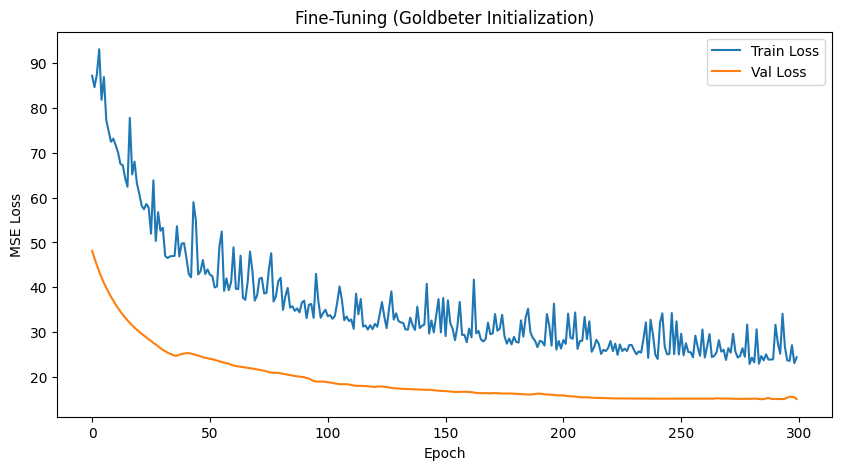

Saved fine-tuned model.


In [ ]:
# Cell 10 (v4): The "Gentle" Fine-Tune (Corrected)
import torch.optim as optim
import matplotlib.pyplot as plt

print("Phase 2: Gentle Fine-tuning on Human Data...")

# 1. Load the biological base (The "Goldbeter Brain")
# This ensures we start with knowledge of the feedback loop, not random noise
try:
    model.load_state_dict(torch.load("models/neural/ab/goldbeter_pretrained.pth"))
    print("Successfully loaded Goldbeter pre-trained weights.")
except FileNotFoundError:
    print("Error: 'goldbeter_pretrained.pth' not found. Please run Cell 8(v2) and Cell 9(v2) first!")
    raise

# 2. Hyperparameters
# We use a VERY LOW learning rate to gently nudge the model
FINE_TUNE_LR = 5e-5
WEIGHT_DECAY = 1e-2 # High regularization to prevent memorizing noise
EPOCHS = 300

# 3. Setup Loaders
train_loader = DataLoader(TensorDataset(train_data, train_mask), batch_size=8, shuffle=True)
val_loader   = DataLoader(TensorDataset(val_data, val_mask), batch_size=8, shuffle=False)

# 4. Optimizer
optimizer = optim.Adam(model.parameters(), lr=FINE_TUNE_LR, weight_decay=WEIGHT_DECAY)
criterion = nn.MSELoss(reduction='none')

history_ft = {'train_loss': [], 'val_loss': []}
t_span = torch.linspace(0, 6, 7).to(device)

print(f"Starting gentle fine-tuning on {device}...")

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0

    for batch_y, batch_mask in train_loader:
        batch_y = batch_y.to(device)
        batch_mask = batch_mask.to(device)

        optimizer.zero_grad()

        y0 = batch_y[:, 0, :]
        pred_y = model(y0, t_span)

        loss_raw = criterion(pred_y, batch_y)
        mask_expanded = batch_mask.unsqueeze(-1)
        loss_masked = loss_raw * mask_expanded
        loss = loss_masked.sum() / mask_expanded.sum()

        # Smoothness Penalty (Total Variation)
        # Keeps the curves looking biological (not jagged)
        loss += 0.01 * torch.mean(torch.abs(pred_y[:, 1:] - pred_y[:, :-1]))

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    history_ft['train_loss'].append(avg_train_loss)

    # --- Validation Step ---
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch_y, batch_mask in val_loader:
            batch_y = batch_y.to(device)
            batch_mask = batch_mask.to(device)

            y0 = batch_y[:, 0, :]
            pred_y = model(y0, t_span)

            loss_raw = criterion(pred_y, batch_y)
            mask_expanded = batch_mask.unsqueeze(-1)
            loss_masked = loss_raw * mask_expanded
            loss = loss_masked.sum() / mask_expanded.sum()

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    history_ft['val_loss'].append(avg_val_loss)

    if epoch % 50 == 0:
        print(f"Epoch {epoch:03d} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(history_ft['train_loss'], label='Train Loss')
plt.plot(history_ft['val_loss'], label='Val Loss')
plt.title("Fine-Tuning (Goldbeter Initialization)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

torch.save(model.state_dict(), "models/neural/ab/neural_ode_finetuned.pth")
print("Saved fine-tuned model.")